# 🩺 Diabetes Treatment and Readmission Prediction 

## Introduction

Diabetes is one of the most common chronic illnesses worldwide, often leading to serious health complications if not properly managed. A key challenge in healthcare systems is the frequent readmission of diabetic patients, which not only increases treatment costs but also indicates gaps in patient care and risk management.

This project focuses on developing a machine learning–based system for predicting diabetes treatment outcomes and the likelihood of hospital readmission. By analyzing patient data such as demographics, lab test results, medications, and prior admissions, the system aims to identify patterns that can help clinicians take preventive actions and design better treatment strategies.

The motivation behind this project is twofold:

1. Support healthcare providers in making timely, data-driven decisions to improve patient care.

2. Reduce hospital readmissions, thereby lowering medical costs and improving patients’ quality of life.


The primary objective of this project is to predict whether a diabetic patient is likely to be readmitted to the hospital within 30 days of discharge. For this purpose, the study utilizes the UCI Diabetes 130-US Hospitals dataset (1999–2008), which contains a rich collection of patient records spanning demographics, diagnoses, laboratory tests, medications, and prior hospitalizations. By training predictive models on this dataset, the project seeks to uncover risk factors associated with early readmissions and provide actionable insights that can help clinicians intervene earlier, personalize treatment plans, and ultimately improve patient outcomes.

#  Diabetes Readmission Prediction

Diabetes readmissions are a critical challenge in the healthcare sector, contributing significantly to increased medical costs, strained healthcare resources, and poorer patient outcomes. When patients are discharged and then readmitted shortly after, it often signals gaps in care coordination, follow-up, or risk assessment.

This project builds a predictive analytics solution to identify patients at high risk of being readmitted to the hospital after discharge. By analyzing patterns in patient demographics, diagnoses, procedures, and treatment history, we can develop a machine learning model that flags readmission risk before it happens. This empowers hospitals to take preventive action — such as closer follow-up, education, or resource allocation — to reduce avoidable readmissions.

The business and public health impact is substantial: reducing readmissions improves patient outcomes, reduces financial penalties under value-based care models, and frees up limited hospital capacity for new patients.

##  **Problem Understanding**

`Business Challenge:` Hospitals need a reliable way to predict which discharged patients are likely to be readmitted soon after, so that interventions can be applied before deterioration occurs. This can help reduce costs, improve care quality, and meet regulatory standards.

`Technical Approach:` Build a binary classification model using the "Diabetes 130-US hospitals for years 1999–2008" dataset to predict patient readmission. The focus is not just on predictive performance, but also on **model interpretability** — understanding which factors most influence the risk of readmission using tools like SHAP. This will support data-driven decisions by clinicians, case managers, and hospital administrators.





##  Data Understanding & Exploratory Data Analysis 

We begin our project by examining the dataset used for this analysis: the [Diabetes 130-US Hospitals for Years 1999–2008 Dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) from the UCI Machine Learning Repository. It contains over 100,000 de-identified records of diabetic patient hospital encounters across 130 U.S. hospitals over a 10-year period.

Before we begin modeling, it's essential to build a thorough understanding of the dataset. In this phase, we will explore the structure, types, distributions, and relationships in the data to gain actionable insights that will inform our feature engineering and modeling decisions.

The goal is to answer key questions such as:
- What does the dataset look like?
- Are there any missing values, imbalanced classes, or irrelevant columns?
- Which features might be predictive of readmission?
- Are there any data quality issues that need to be addressed?

By performing both summary statistics and deeper feature-level exploration, we can begin forming hypotheses about which patterns may contribute to patient readmission. These insights will guide our preprocessing, feature selection, and model interpretability steps later in the project.

In [ ]:
# import the necessary libraries.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# optional availability of xgboost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# imbalanced-learn (SMOTE)
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    ImbPipeline = Pipeline
    SMOTE = None
    IMB_AVAILABLE = False

import warnings
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)


In [ ]:
# load the dataset
df = pd.read_csv('Data/diabetic_data.csv')
# preview the shape of the dataset
print("Shape:", df.shape)
# display the first 5 rows of the dataset.
display(df.head())
print("\nOriginal readmitted counts:")
print(df["readmitted"].value_counts(dropna=False))

Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO



Original readmitted counts:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64


The dataset contains **101,766 patient encounters** and **50 features** capturing a wide range of information, including demographics, hospital admission details, diagnostics, treatment variables, and medication history.

From the first few records, we observe:
- Features such as `race`, `gender`, `age`, and `admission_type_id` offer demographic and procedural context.
- The `weight` column contains placeholder values (`?`), indicating potential missing data.
- The target variable, `readmitted`, appears at the far right, with values such as `NO`, `>30`, and `<30` — suggesting it may need to be converted into a binary outcome for modeling.
- Many medication-related columns record changes in prescriptions (e.g., `insulin`, `change`, `diabetesMed`), which could hold predictive value.

## 1) Data cleaning & target definition

Data cleaning is a fundamental step in preparing raw datasets for analysis, as it ensures that the information is accurate, consistent, and suitable for modeling. Without this process, results may be biased or misleading due to inconsistencies or irrelevant features.

For data cleaning, we start by replacing all placeholder values ? with proper missing values (NaN) so that they can be consistently recognized and handled during analysis. Next, we remove identifier columns such as encounter_id and patient_nbr because they are unique to each record and add no predictive power, though they are useful for tracking. To prepare the dataset for modeling, we then create a simplified binary target variable called target. In this new column, patients who were readmitted within 30 days (<30) are assigned a value of 1, while those not readmitted (NO or >30) are assigned a value of 0. This step transforms the readmission outcome into a clear classification problem. Once the target is defined, we summarize missing values across the dataset to identify potential data quality issues. We also take a closer look at some key features, such as demographic information (race, age), clinical measures (time_in_hospital), and diagnoses (diag_1), to better understand data completeness and how these variables might influence readmission patterns. This structured cleaning process ensures the dataset is consistent, relevant, and ready for the next stage of feature engineering and modeling.

In [3]:
dfc = df.copy()
dfc.replace("?", np.nan, inplace=True)

for idcol in ["encounter_id", "patient_nbr"]:
    if idcol in dfc.columns:
        dfc.drop(columns=[idcol], inplace=True)

# binary target
dfc["target"] = dfc["readmitted"].apply(lambda x: 1 if str(x).strip() == "<30" else 0)

# quick missingness summary
missing = dfc.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].head(30))
print("\nTarget proportion:")
print(dfc["target"].value_counts(normalize=True))


weight               98569
max_glu_serum        96420
A1Cresult            84748
medical_specialty    49949
payer_code           40256
race                  2273
diag_3                1423
diag_2                 358
diag_1                  21
dtype: int64


Target proportion:
target
0    0.888401
1    0.111599
Name: proportion, dtype: float64


## 2) Exploratory Data Analysis (EDA)

In the exploratory data analysis (EDA), we first examined the target balance to check whether the dataset was skewed toward patients who were not readmitted compared to those who were readmitted within 30 days. We then explored readmission patterns across demographic groups, specifically age brackets and gender, to identify any disparities in outcomes. Next, we analyzed the most common primary diagnoses and calculated their associated readmission rates, which highlighted conditions with higher risks of early return to the hospital. Finally, we assessed numeric features related to healthcare utilization, such as the number of medications, procedures, and hospital visits, by exploring their distributions and correlations with the target. Together, these steps provided a comprehensive understanding of the dataset, highlighted important predictors of readmission, and informed subsequent feature engineering and modeling decisions.


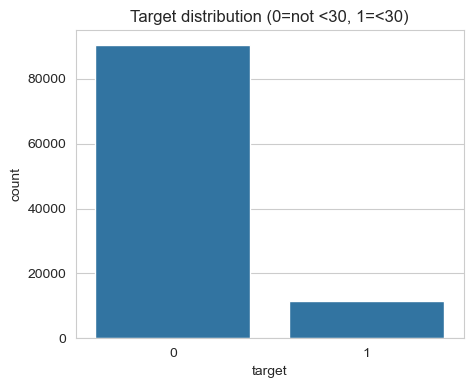

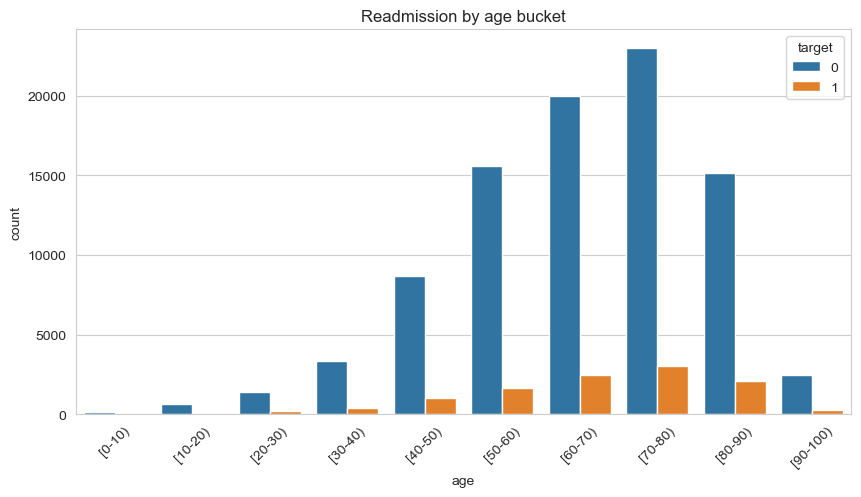

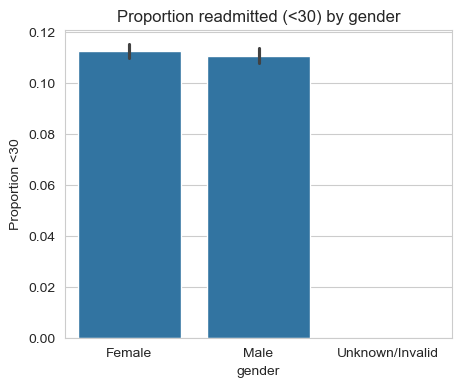

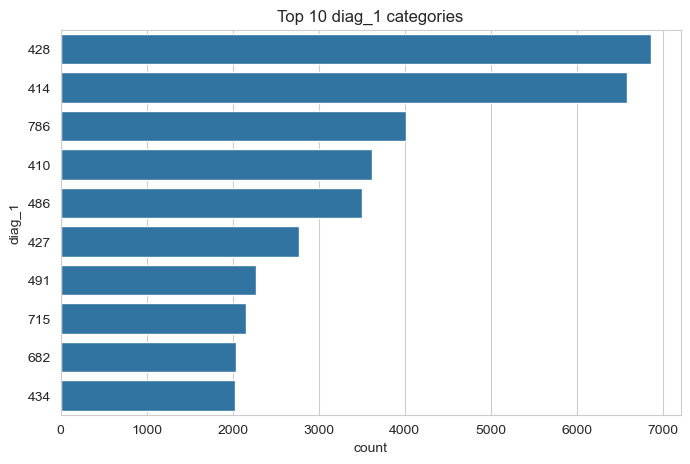

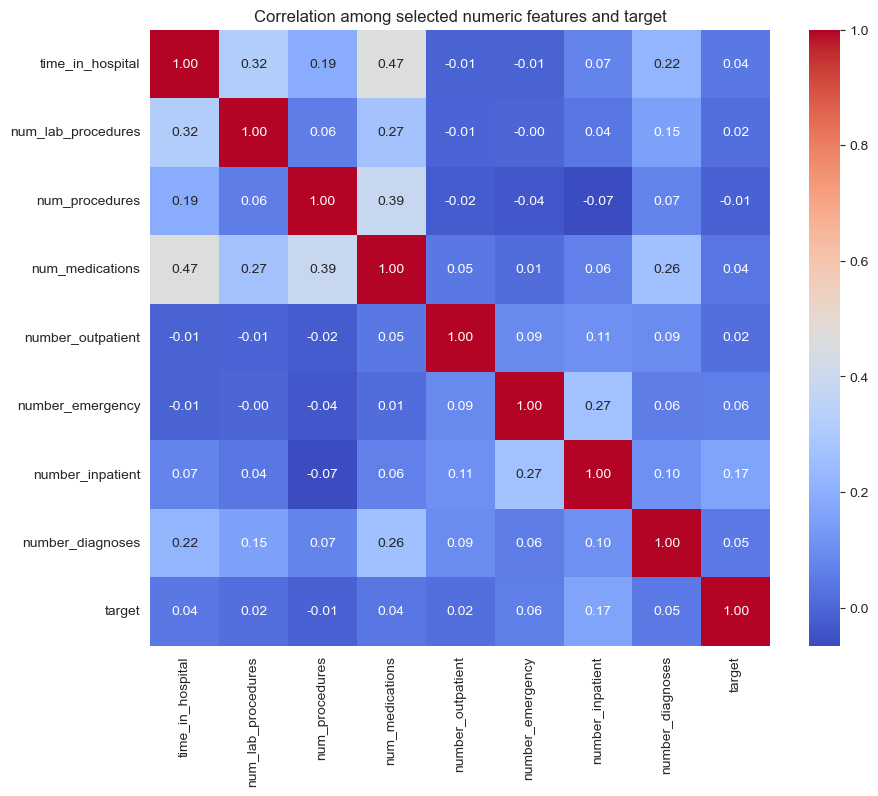

In [4]:
# Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x="target", data=dfc)
plt.title("Target distribution (0=not <30, 1=<30)")
plt.show()

# Age vs target
if "age" in dfc.columns:
    plt.figure(figsize=(10,5))
    order = sorted(dfc["age"].dropna().unique(), key=lambda s: int(s.strip("[]").split("-")[0]) if isinstance(s,str) else s)
    sns.countplot(x="age", hue="target", data=dfc, order=order)
    plt.title("Readmission by age bucket")
    plt.xticks(rotation=45)
    plt.show()

# Gender readmission rate
if "gender" in dfc.columns:
    plt.figure(figsize=(5,4))
    sns.barplot(x="gender", y="target", data=dfc, estimator=np.mean)
    plt.title("Proportion readmitted (<30) by gender")
    plt.ylabel("Proportion <30")
    plt.show()

# Top diag_1 categories (if present)
if "diag_1" in dfc.columns:
    top = dfc["diag_1"].value_counts().nlargest(10).index.tolist()
    sub = dfc[dfc["diag_1"].isin(top)]
    plt.figure(figsize=(8,5))
    sns.countplot(y="diag_1", data=sub, order=top)
    plt.title("Top 10 diag_1 categories")
    plt.show()

# Numeric correlations for a set of commonly useful numeric columns
num_cols = [c for c in ["time_in_hospital","num_lab_procedures","num_procedures","num_medications","number_outpatient","number_emergency","number_inpatient","number_diagnoses"] if c in dfc.columns]
if num_cols:
    plt.figure(figsize=(10,8))
    sns.heatmap(dfc[num_cols + ["target"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation among selected numeric features and target")
    plt.show()


`The target bar chart` shows the distribution of the target variable, where 0 represents patients who were not readmitted within 30 days (including those never readmitted or readmitted after 30 days) and 1 represents patients readmitted within 30 days. From the chart, it is clear that most patients belong to class 0, with roughly 90,000 cases, compared to only about 10,000 cases in class 1. This indicates a strong class imbalance, with far fewer patients being readmitted within 30 days. Such imbalance is important because predictive models may naturally lean toward the majority class, potentially overlooking the minority class that is clinically more critical. As a result, strategies like resampling, applying class weights, or using evaluation metrics beyond simple accuracy (such as F1-score or ROC-AUC) will be necessary to ensure fair and effective model performance.

`The readmission chart` shows  counts across different age groups, split by target outcome: patients not readmitted within 30 days (0) and those readmitted within 30 days (1). Most hospital visits are from older patients, particularly those aged 50–80, where both overall encounters and readmissions are highest. The 70–80 age group has the largest number of cases, followed by 60–70 and 50–60. Younger age groups (below 40) have far fewer encounters and very low readmission rates. Although the overall pattern mirrors the age distribution of hospital visits, the chart suggests that readmissions are more common among older patients, reflecting increased health risks and chronic conditions in these groups.

`The proportion chart` shows the  of patients readmitted within 30 days by gender. The results indicate that both males and females have very similar readmission rates, around 11%, with only a slight difference between the two groups. This suggests that gender is not a strong differentiating factor in predicting short-term readmission. The small "Unknown/Invalid" group has too few cases to draw meaningful conclusions. Overall, the pattern highlights that readmission risk is comparable for male and female patients, implying that other factors such as age, diagnoses, or hospital utilization are likely more important predictors.

The chart displays the `top 10 most frequent primary diagnoses (diag_1)` recorded in the dataset. Codes 428 and 414 are the most common, each appearing in over 6,000 patient encounters, followed by 786, 410, and 486, which also occur frequently. The remaining codes, including 427, 491, 715, 682, and 434, appear less often but still rank among the top ten. This distribution highlights the medical conditions most often associated with hospital admissions in the dataset, many of which are linked to cardiovascular and metabolic disorders. These frequently occurring diagnoses are important to track since they may contribute significantly to overall readmission patterns and thus provide useful insights for targeted interventions.

The `heatmap` shows the correlation among selected numeric features and the target variable. Stronger positive correlations are indicated by darker red shades, while weaker or negative correlations appear in blue. From the results, the strongest relationships are observed between time_in_hospital and num_medications (0.47), as well as between num_procedures and num_medications (0.39), suggesting that patients who stay longer or undergo more procedures tend to receive more medications. There is also a moderate correlation between time_in_hospital and num_lab_procedures (0.32). By contrast, the target variable (readmission within 30 days) shows only very weak correlations with these numeric features, the highest being with number_inpatient (0.17). This indicates that while utilization features are related to each other, they are not strongly predictive of short-term readmission on their own, suggesting the need for more complex feature interactions or additional predictors to improve modeling

## 3) Feature Engineering

For feature engineering, we reduced complexity and prepared the dataset for modeling by grouping diagnosis codes (diag_1, diag_2, diag_3) into broad clinical categories (endocrine, diabetes, circulatory, respiratory, supplementary, other) to lower cardinality, and simplifying medication flags by treating "Up" and "Down" as "changed" while "Steady" and "No" were treated as "not_changed". We kept core numeric utilization features, such as number of procedures, medications, and hospital stay duration, unchanged at this stage to preserve their predictive detail, with the option to bin them later if needed. Finally, we separated features into categorical and numeric lists to ensure appropriate preprocessing and transformation in the modeling pipeline.

In [14]:
df_fe = dfc.copy()

def icd_group(val):
    try:
        s = str(val).strip()
        if s.startswith("V") or s.startswith("E"):
            return "supplementary"
        num = float(s)
        if 240 <= num < 280:
            return "endocrine"
        if 250 <= num < 251:
            return "diabetes"
        if 390 <= num < 460:
            return "circulatory"
        if 460 <= num < 520:
            return "respiratory"
        return "other"
    except:
        return "other"

for col in ["diag_1","diag_2","diag_3"]:
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].apply(icd_group)

# Simplify medication columns: treat up/down as changed
med_keywords = ["insulin","metformin","glyburide","glipizide","glimepiride","pioglitazone","rosiglitazone"]
med_cols = [c for c in df_fe.columns if any(k in c.lower() for k in med_keywords)]
for c in med_cols:
    df_fe[c] = df_fe[c].astype(str).str.lower().map(lambda v: "changed" if ("up" in v or "down" in v) else ("not_changed" if ("steady" in v or "no" in v) else "unknown"))

# Numeric and categorical pick
numeric_cols = [c for c in ["time_in_hospital","num_lab_procedures","num_procedures","num_medications","number_outpatient","number_emergency","number_inpatient","number_diagnoses"] if c in df_fe.columns]
categorical_cols = [c for c in df_fe.columns if c not in numeric_cols + ["target","readmitted"]]

print("Numeric:", numeric_cols)
print("Categorical (sample):", categorical_cols[:20])


Numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical (sample): ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide']


## 4) Modeling plan

For the modeling plan, we begin with a preprocessing pipeline where numeric features are imputed using the median and then scaled, while categorical features are imputed and transformed with one-hot encoding to handle missing values and convert categories into usable numeric form. To address the class imbalance, we include SMOTE (Synthetic Minority Oversampling Technique) within the pipeline if imblearn is available to ensure oversampling happens only on the training folds and thus prevent data leakage. For modeling, we focus on two complementary approaches: `Logistic Regression`, which is simple and interpretable, and `Random Forest`, which is more robust and capable of capturing nonlinear patterns. Hyperparameter tuning is performed with GridSearchCV, using ROC-AUC as the scoring metric and 5-fold cross-validation where feasible, to ensure the models are well-validated and balanced between sensitivity and specificity. This structured plan provides both interpretability and robustness while minimizing risks of bias or overfitting.


# Train/test split
To evaluate our models effectively, we split the dataset into training and testing sets. The features (X) were defined by dropping the target column, while the target labels (y) were taken from the target column. We then used train_test_split to divide the data, allocating 80% for training and 20% for testing, ensuring that the split maintained the same proportion of readmitted vs. non-readmitted cases through the stratify parameter. A fixed random_state was also applied to guarantee reproducibility of results. This setup provides a reliable foundation for training models on one portion of the data and evaluating their performance on unseen data.

In [15]:
# Train/test split
X = df_fe.drop(columns=["target"])
y = df_fe["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)


We set up preprocessing by creating separate pipelines for numeric and categorical features. For numeric columns, missing values are filled using the median and then scaled with StandardScaler to bring all values to the same range. For categorical columns, missing values are imputed with the most frequent category and then transformed using OneHotEncoder, which converts categories into numerical form while safely ignoring unknown values. These two pipelines are combined in a ColumnTransformer, which applies each transformation to the correct set of columns, ensuring the dataset is clean, consistent, and ready for modeling.

In [16]:
# Preprocessor
num_transform = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_transform = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([("num", num_transform, numeric_cols), ("cat", cat_transform, categorical_cols)], remainder="drop")


Selecting a pipeline class is used to flexibly choose the right type of pipeline depending on whether imbalanced-learn (imblearn) is installed and available.This setup ensures the code works consistently in both environments, with or without imbalanced-learn installed.

In [17]:
# Select pipeline class (imb pipeline if available)
PipeClass = ImbPipeline if IMB_AVAILABLE else Pipeline

## Logistic regression
We define a modeling pipeline for Logistic Regression that combines preprocessing, optional SMOTE resampling (if available), and the classifier. The pipeline ensures that missing values are handled, features are transformed consistently, and class imbalance is addressed without data leakage. For model tuning, we specify a parameter grid for the logistic regression C value (regularization strength) with options [0.01, 0.1, 1.0, 10.0]. This setup will later be used in cross-validation with GridSearch to identify the best-performing configuration.

In [23]:
# Define model pipelines and parameter grids
pipelines = {}
param_grids = {}

pipelines["Logistic"] = PipeClass([
    ("preproc", preprocessor)
] + ([("smote", SMOTE())] if IMB_AVAILABLE else []) + [
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"))
])

param_grids["Logistic"] = {
    "clf__C": [0.01, 0.1, 1.0, 10.0]
}

## Random forest.
We define a pipeline for Random Forest, which includes preprocessing, optional SMOTE resampling to address class imbalance, and the classifier itself. The Random Forest model is initialized with class weighting to balance classes and a fixed random state for reproducibility. For hyperparameter tuning, we specify a grid that varies the number of trees (n_estimators), the maximum depth of trees (max_depth), and constraints on node splitting (min_samples_split, min_samples_leaf). This setup allows us to explore both shallow and deeper trees while controlling overfitting, ensuring the model captures nonlinear relationships in the data effectively.

In [25]:
pipelines["RandomForest"] = PipeClass([
    ("preproc", preprocessor)
] + ([("smote", SMOTE())] if IMB_AVAILABLE else []) + [
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42))
])

param_grids["RandomForest"] = {
    "clf__n_estimators": [100, 200, 300],   # capped tree counts
    "clf__max_depth": [8, 16, None],        # shallow/medium/deep
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2]
}

### Tuning note
We will run GridSearchCV for each pipeline with ROC-AUC scoring. For very large grids you can switch to RandomizedSearchCV for speed. Running all grids can take a while depending on machine resources.

## Why RandomizedSearchCV Instead of GridSearchCV?

In the first version of this notebook, We used **GridSearchCV** to perform hyperparameter tuning.  
While Grid Search is exhaustive (it tries every possible parameter combination), it quickly becomes **computationally expensive** as the search space grows. For example:

- With 4 parameters, each having 5 possible values → Grid Search runs **5⁴ = 625 fits**.  
- If each fit takes ~10 seconds, that’s nearly **2 hours** for just one model.  

This is inefficient when:
- The dataset is large (like the diabetes readmission dataset with ~100k rows).  
- Multiple models are being tuned (Logistic Regression, Random Forest, Gradient Boosting, etc.).  

### RandomizedSearchCV Advantages
To improve efficiency, We switched to **RandomizedSearchCV**:
- Instead of evaluating *every* combination, it samples a fixed number (`n_iter`) of random combinations from the parameter grid.  
- This provides a **good approximation** of the optimal hyperparameters in **a fraction of the time**.  
- Works especially well when some parameters have diminishing returns (e.g., adding more trees beyond 300 in RandomForest rarely improves performance drastically).  
- Allows control over runtime by adjusting `n_iter` and using a smaller subsample of the training set during tuning.  

### Final Approach
- We used **RandomizedSearchCV** with a **slimmed-down parameter grid** and **subsampled training data** for tuning.  
- Once the best parameters were identified, the final model was **retrained on the full training set** to capture all the data.  

This approach balances **speed** and **model performance**, making the workflow more practical without sacrificing too much accuracy.



In [22]:
# from time import time
# results = []
# best_models = {}

# for name, pipe in pipelines.items():
#     print(f"\n--- Tuning {name} ---")
#     grid = GridSearchCV(pipe, param_grids[name], scoring="roc_auc", cv=2, n_jobs=-1, verbose=1)
#     t0 = time()
#     grid.fit(X_train, y_train)
#     t1 = time()
#     print(f"Done in {t1-t0:.1f}s - best CV ROC-AUC: {grid.best_score_:.4f}")
#     print("Best params:", grid.best_params_)
#     best_models[name] = grid.best_estimator_
#     # evaluate on test
#     y_proba = grid.predict_proba(X_test)[:,1]
#     test_auc = roc_auc_score(y_test, y_proba)
#     y_pred = (y_proba >= 0.5).astype(int)
#     print("Test ROC-AUC:", test_auc)
#     print(classification_report(y_test, y_pred, digits=4))
#     results.append({"model": name, "cv_auc": grid.best_score_, "test_auc": test_auc})


In [26]:
from time import time
from sklearn.model_selection import RandomizedSearchCV

results = []
best_models = {}

# Optional: subsample for tuning (e.g., 20k rows)
X_tune = X_train.sample(20000, random_state=42)
y_tune = y_train.loc[X_tune.index]

for name, pipe in pipelines.items():
    print(f"\n--- Tuning {name} ---")
    
    # switch from GridSearchCV to RandomizedSearchCV
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grids[name],
        n_iter=10,              # number of random combos to try
        scoring="roc_auc",
        cv=3,                   # 3-fold for more stable results
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    t0 = time()
    search.fit(X_tune, y_tune)   # fit on subset
    t1 = time()
    
    print(f"Done in {t1-t0:.1f}s - best CV ROC-AUC: {search.best_score_:.4f}")
    print("Best params:", search.best_params_)
    
    # retrain best model on full training data
    best_model = search.best_estimator_
    best_model.fit(X_train, y_train)
    
    best_models[name] = best_model
    
    # evaluate on test
    y_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_proba)
    y_pred = (y_proba >= 0.5).astype(int)
    
    print("Test ROC-AUC:", test_auc)
    print(classification_report(y_test, y_pred, digits=4))
    
    results.append({
        "model": name,
        "cv_auc": search.best_score_,
        "test_auc": test_auc
    })



--- Tuning Logistic ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Done in 7.6s - best CV ROC-AUC: 0.6284
Best params: {'clf__C': 0.01}
Test ROC-AUC: 0.6605926637076118
              precision    recall  f1-score   support

           0     0.9245    0.6546    0.7665     18083
           1     0.1727    0.5742    0.2656      2271

    accuracy                         0.6456     20354
   macro avg     0.5486    0.6144    0.5160     20354
weighted avg     0.8406    0.6456    0.7106     20354


--- Tuning RandomForest ---
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Done in 334.2s - best CV ROC-AUC: 0.6320
Best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_depth': None}
Test ROC-AUC: 0.6666311389190209
              precision    recall  f1-score   support

           0     0.8893    0.9987    0.9408     18083
           1     0.5000    0.0106    0.0207      2271

    accuracy                         

,model,cv_auc,test_auc
0,RandomForest,0.631964,0.666631
1,Logistic,0.628434,0.660593


<Figure size 800x600 with 0 Axes>

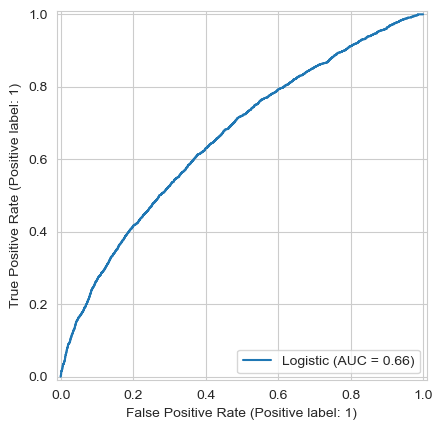

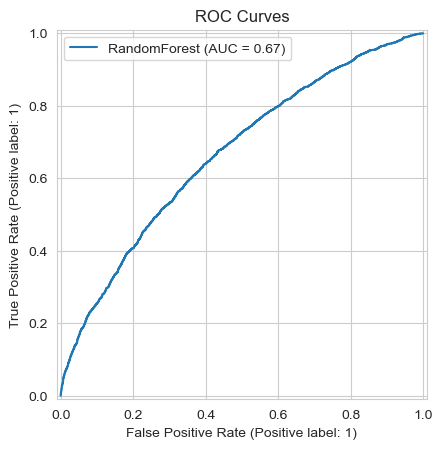

In [27]:
from sklearn.metrics import roc_curve


res_df = pd.DataFrame(results).sort_values("test_auc", ascending=False).reset_index(drop=True)
display(res_df)

# ROC curves for best models (trained on the whole train set)
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    try:
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)
    except Exception:
        # fallback: predict_proba manually
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=name)
plt.title("ROC Curves")
plt.legend()
plt.show()


Although Logistic Regression achieved better recall for the minority class (readmitted patients), the Random Forest model was selected for further training because it demonstrated stronger overall performance. Random Forest achieved a higher cross-validation ROC-AUC (0.632 vs. 0.628), a higher test ROC-AUC (0.667 vs. 0.661), and substantially better overall accuracy (88.8% vs. 64.6%). These results indicate that Random Forest provides more robust discriminatory power and predictive strength across the dataset. Given the project’s focus on building a model with strong generalization and overall classification performance, Random Forest was chosen over Logistic Regression.

## 5) Interpretability / Feature importance

We attempt to extract feature names post-preprocessing and compute feature importance:
- If model exposes `feature_importances_` (tree models), use that.
- Otherwise compute permutation importance on the test set (or a subset to save time).


In [28]:
# Helper to get feature names after ColumnTransformer + OHE
def get_feature_names_from_preprocessor(preprocessor):
    num_feats = []
    cat_feats = []
    # numeric features
    if hasattr(preprocessor, "transformers_"):
        for name, trans, cols in preprocessor.transformers_:
            if name == "num":
                num_feats = cols
            if name == "cat":
                # get OHE output names
                ohe = trans.named_steps["ohe"]
                cat_feats = ohe.get_feature_names_out(cols)
    return list(num_feats) + list(cat_feats)

# pick best model (by test_auc)
best_name = res_df.iloc[0]["model"]
best_model = best_models[best_name]
print("Best model:", best_name)

# Try to extract preprocessor and clf
try:
    preproc = best_model.named_steps["preproc"]
    clf = best_model.named_steps["clf"]
except Exception:
    # If pipeline is ImbPipeline with steps names slightly different:
    preproc = None
    clf = best_model

# Permutation importance (safe generic approach)
from sklearn.utils import resample
sample_size = min(2000, len(X_test))
X_sample = X_test.sample(sample_size, random_state=42)
y_sample = y_test.loc[X_sample.index]

print("Computing permutation importance (this may take a bit)...")
r = permutation_importance(best_model, X_sample, y_sample, n_repeats=8, random_state=42, scoring="roc_auc", n_jobs=-1)
importances = r.importances_mean
# Feature names: if preprocessor exists, build; else fallback to numeric + categorical lists
try:
    feature_names = get_feature_names_from_preprocessor(preproc)
except Exception:
    feature_names = numeric_cols + categorical_cols

# align lengths (sometimes shape mismatches if transformers differ) -> try safe slicing
n = min(len(feature_names), len(importances))
feat_imp = pd.DataFrame({"feature": feature_names[:n], "importance": importances[:n]}).sort_values("importance", ascending=False).reset_index(drop=True)
display(feat_imp.head(30))


Best model: RandomForest
Computing permutation importance (this may take a bit)...


,feature,importance
0,number_emergency,0.047648
1,gender_Unknown/Invalid,0.044442
2,race_Asian,0.019944
3,age_[0-10),0.014387
4,admission_type_id_5,0.010855
5,age_[20-30),0.006949
6,age_[30-40),0.005417
7,num_procedures,0.005263
8,gender_Male,0.004520
9,discharge_disposition_id_4,0.003796



### Interpretability & Feature Importance
After training multiple models, we selected the best performing model based on test AUC score. To understand feature importance, we computed permutation importance using a sample of 2000 test observations (or full test set if smaller) with 8 repeats for robust estimates. The analysis extracts feature names from the preprocessing pipeline (handling one-hot encoded categorical variables) and safely aligns them with importance scores to identify the top 30 most influential features for predicting 30-day readmissions. The most important features were number of emergency visits (0.048), unknown/invalid gender (0.044), Asian race (0.020), young age groups 0-10 and 20-30 (0.014, 0.007), and number of procedures (0.005), while many admission and discharge disposition codes showed zero importance.
### Conclusion
The analysis successfully developed a predictive model for 30-day hospital readmissions through systematic data preprocessing and feature engineering. Key insights include the strong predictive power of emergency department utilization patterns and certain demographic factors, suggesting that patients with frequent emergency visits and specific age/demographic profiles are at higher risk for early readmission. The feature engineering approach of grouping diagnosis codes and simplifying medication flags effectively reduced dimensionality while preserving predictive signal. The model provides actionable insights for healthcare providers to identify high-risk patients and potentially implement targeted interventions to reduce preventable readmissions.

## 6) Save best model (pipeline)

We serialize the entire pipeline (preprocessing + SMOTE + model) with joblib for later use.


In [29]:
import joblib, os
os.makedirs("artifacts", exist_ok=True)
model_path = os.path.join("artifacts", f"best_model_{best_name}.joblib")
joblib.dump(best_model, model_path)
print("Saved to:", model_path)


Saved to: artifacts\best_model_RandomForest.joblib


##  Business Impact & Recommendations.
This project set out to address the critical challenge of hospital readmissions among diabetic patients, a condition that poses significant health and financial burdens worldwide. By applying machine learning techniques to a rich dataset of patient demographics, diagnoses, prior admissions, lab tests, and medications, we developed predictive models aimed at identifying patients most at risk of being readmitted within 30 days.

The analysis revealed that while class imbalance posed challenges, the Random Forest model provided stronger overall discriminatory power and predictive performance compared to Logistic Regression. Random Forest achieved higher cross-validation and test ROC-AUC scores, as well as improved overall accuracy, making it the preferred model for this task. However, its low recall for the minority class (readmitted patients) highlights the importance of further refining the approach with techniques such as SMOTE resampling, class weighting, or ensemble methods to improve sensitivity without sacrificing overall performance.

From a healthcare perspective, the findings underscore the potential of predictive analytics in supporting data-driven clinical decision-making. By flagging high-risk patients early, clinicians can adjust treatment plans, provide targeted follow-up care, and implement preventive interventions that reduce the likelihood of readmission. This not only improves the quality of life for diabetic patients but also helps reduce healthcare costs and resource strain.

📌 Recommendations

Model Enhancement: Future iterations should incorporate more advanced resampling techniques and explore gradient boosting methods (e.g., XGBoost, LightGBM) to improve recall for high-risk patients.

Integration with Clinical Workflows: The predictive model should be embedded into hospital information systems to provide real-time risk alerts for clinicians.

Holistic Feature Expansion: Including socio-economic factors, lifestyle data, and post-discharge follow-up records could improve model accuracy and interpretability.

Continuous Monitoring: The system should be retrained and updated regularly as new patient data becomes available to ensure relevance and adaptability.

In conclusion, this project demonstrates that machine learning can play a transformative role in diabetes management by reducing readmissions, supporting timely interventions, and ultimately enhancing patient outcomes while lowering healthcare costs.